# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [1]:
!pip install gdown mediapipe imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 31.8 MB/s eta 0:00:00


In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 19.0 MB/s eta 0:00:00


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import mediapipe as mp
import glob

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#     print("ok no probs")
#     pass

# 1. Build Data Loading Functions

In [4]:

def load_word_images(path: str) -> List[float]:
    frames = []

    with mp.solutions.face_mesh.FaceMesh() as face:
        for image_name in os.listdir(path):

            image = imageio.v2.imread(os.path.join(path, image_name))

            if image is not None:
                results = face.process(image)

                landmarks = results.multi_face_landmarks[0].landmark
                x1, y1 = map(int, (landmarks[0].x * image.shape[1], landmarks[0].y * image.shape[0]))
                x2, y2 = map(int, (landmarks[17].x * image.shape[1], landmarks[17].y * image.shape[0]))

                x = (x1 + x2) // 2 - 70 * 2
                y = (y1 + y2) // 2 - 22 * 3

                cropped_image = image[y:y+135, x:x+280]

                pad_height = max(0, 135 - cropped_image.shape[0])
                pad_width = max(0, 280 - cropped_image.shape[1])
                try:
                    padded_image = tf.image.pad_to_bounding_box(
                    cropped_image, 0, 0, cropped_image.shape[0] + pad_height, cropped_image.shape[1] + pad_width
                    )
                    frame = tf.image.rgb_to_grayscale(padded_image)
                    frames.append(frame)
                except:
                    frame = tf.image.rgb_to_grayscale(cv2.resize(cropped_image,(280,135)))
                    frames.append(frame)

            else:
                pass

    return tf.cast(tf.image.per_image_standardization(frames), tf.float32)


In [5]:
vocab = ['অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ',
    'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট',
    'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ',
    'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়',
    'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ', '০', '১', '২', '৩', '৪',
    '৫', '৬', '৭', '৮', '৯','়','া','ি','ী','ু','ূ','ৃ','ে',
    'ৈ','ো','ৌ','্',' '
]

len(vocab)

73

In [6]:
char_to_num = tf.keras.layers.StringLookup(
    vocabulary=vocab,oov_token='', mask_token=None  # Set mask_token to None
)

num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),oov_token='', mask_token=None, invert=True,encoding=None
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ', 'ং', 'ঃ', 'ঁ', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', ' '] (size =74)


In [7]:
char_to_num.vocabulary_size()+1

75

In [8]:
char_to_num.get_vocabulary()
char_to_num(['ব','া','ন','ভ'])
num_to_char([34, 62, 31, 35])

output = num_to_char([ 1, 30, 72, 37, 37, 61, 31])

# Convert bytes to strings
output_strings = [char.decode('utf-8') for char in output.numpy()]

print(output_strings)


['অ', 'ধ', '্', 'য', 'য', '়', 'ন']


In [9]:
def load_alignments(path:str) -> List[str]:
    tokens=path.split('\\')[-1]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))#-1 for flattening the latters of word

In [10]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    frames = load_word_images(path)
    alignments = load_alignments(path)

    return frames, alignments

In [11]:
import gdown

In [18]:
urlink='https://drive.google.com/file/d/1DdQ6rN7NyfxGMUVYM2t2DOm86m8phSbQ/view?usp=sharing'
#url = 'https://drive.google.com/uc?id=1DdQ6rN7NyfxGMUVYM2t2DOm86m8phSbQ'
id=urlink.split('/')[-2]
url=f"https://drive.google.com/uc?id={id}"
id
url

'https://drive.google.com/uc?id=1DdQ6rN7NyfxGMUVYM2t2DOm86m8phSbQ'

In [ ]:

output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [20]:
speaker='s22'
test_path = f"/content/{speaker}/শিক্ষাপ্রতিষ্ঠান"


In [21]:
bytes.decode(tf.convert_to_tensor(test_path).numpy())

'/content/s22/শিক্ষাপ্রতিষ্ঠান'

In [22]:
frame, alignment = load_data(tf.convert_to_tensor(test_path))

In [23]:
alignment

<tf.Tensor: shape=(29,), dtype=int64, numpy=
array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40, 63, 12, 72,
       41, 62, 32, 72, 38, 27, 63, 41, 72, 23, 62, 31])>

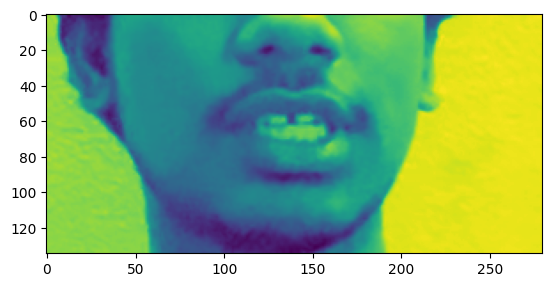

In [24]:
plt.imshow(frame[10])

In [25]:
output_strings = [char.decode('utf-8') for char in num_to_char([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40, 63, 12, 72, 41,
       62, 32, 72, 38, 27, 63, 41, 72, 23, 62, 31]).numpy()]

print(''.join(output_strings))

শিক্ষাপ্রতিষ্ঠান


In [26]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
# @title 1.1 Cleaning Dataset


In [71]:
import shutil

In [72]:
dataset_path=r'/content/s22'

In [73]:
for i in os.listdir(dataset_path):
    if len(os.listdir(os.path.join(dataset_path,i)))<5 :
        print(len(os.listdir(os.path.join(dataset_path,i))))
        shutil.rmtree(os.path.join(dataset_path,i))
        print(i)

In [80]:
for i in os.listdir(dataset_path):
    if len(os.listdir(os.path.join(dataset_path,i)))>45 :
        print(len(os.listdir(os.path.join(dataset_path,i))))
        print(i)

# 2. Create Data Pipeline

In [61]:
file_paths = glob.glob(os.path.join(r'//',r'content',speaker, '*'))
len(file_paths)

460

In [151]:

data = tf.data.Dataset.from_tensor_slices(file_paths)
data = data.shuffle(len(file_paths))
data = data.map(mappable_function)
batch_size=1
data = data.padded_batch(batch_size, padded_shapes=([45,None,None,None],[45]))#25 is the optimal value
data = data.prefetch(tf.data.AUTOTUNE)


In [129]:
# Added for split
train = data.take(int(len(file_paths)*.9/batch_size))
test = data.skip(int(len(file_paths)*.9/batch_size))

In [130]:
print(len(train))
len(test)

414


46

In [131]:
frames,alignments=data.as_numpy_iterator().next()

In [132]:
for element in data.take(5):  # Take the first 5 elements for inspection
    print("Element shapes:")
    print([tf.shape(e) for e in element])


Element shapes:
[<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  1,  45, 135, 280,   1], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 45], dtype=int32)>]
Element shapes:
[<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  1,  45, 135, 280,   1], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 45], dtype=int32)>]
Element shapes:
[<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  1,  45, 135, 280,   1], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 45], dtype=int32)>]
Element shapes:
[<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  1,  45, 135, 280,   1], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 45], dtype=int32)>]
Element shapes:
[<tf.Tensor: shape=(5,), dtype=int32, numpy=array([  1,  45, 135, 280,   1], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 45], dtype=int32)>]


In [68]:
# frames.shape
# type(sample)
# len(val)
#print(val[0].shape)
#print(val[0][0].shape)

In [133]:
sample = data.as_numpy_iterator()
val = sample.next()

In [134]:
gif = (val[0][0] * 255).astype(np.uint8).reshape((45, 135, 280))
imageio.mimsave('/content/animation.gif', gif, fps=10)

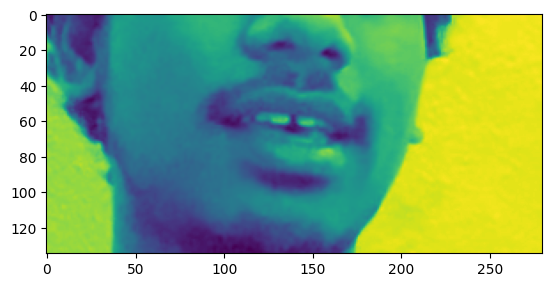

In [135]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][1])

In [136]:
output_strings = [char.decode('utf-8') for char in num_to_char(val[1][0]).numpy() if not char.decode('utf-8')=='[UNK]']

print(''.join(output_strings))

ব্যয়


# 3. Design the Deep Neural Network

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [138]:
data.as_numpy_iterator().next()[0][0].shape

(45, 135, 280, 1)

In [139]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(45,135,280,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(45, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [140]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 45, 135, 280, 12   3584      
                             8)                                  
                                                                 
 activation_9 (Activation)   (None, 45, 135, 280, 12   0         
                             8)                                  
                                                                 
 max_pooling3d_9 (MaxPoolin  (None, 45, 67, 140, 128   0         
 g3D)                        )                                   
                                                                 
 conv3d_10 (Conv3D)          (None, 45, 67, 140, 256   884992    
                             )                                   
                                                                 
 activation_10 (Activation)  (None, 45, 67, 140, 256  

In [ ]:
# 45*16*35
# yhat = model.predict(val[0])
# # yhat.shape
# # yhat[0][0].shape
# print(tf.argmax(yhat[0],axis=1).numpy())
# output_strings = [char.decode('utf-8') for char in num_to_char(tf.argmax(yhat[0],axis=1)).numpy()]

# print(''.join(output_strings))

In [141]:
model.input_shape

(None, 45, 135, 280, 1)

In [142]:
model.output_shape

(None, 45, 75)

# 4. Setup Training Options and Train

In [143]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [144]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")# for alignment batch
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64") # len of predicted align
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [145]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        ip_len=np.full((yhat.shape[0]),yhat.shape[1])
        decoded = tf.keras.backend.ctc_decode(yhat, ip_len, greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            #char.decode('utf-8') for char in num_to_char(tf.argmax(yhat[0],axis=1)).numpy()
            oos=[char.decode('utf-8') for char in num_to_char(data[1][x]).numpy() if char.decode('utf-8')!='[UNK]']
            oo=''.join(oos)
            print('Original:', oo)
            pos=[char.decode('utf-8') for char in num_to_char(decoded[x]).numpy() if char.decode('utf-8')!='[UNK]']
            po=''.join(pos)
            print('Prediction:', po)
            print('~'*100)


In [146]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [147]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss',monitor='accuracy' save_weights_only=True)

In [148]:
schedule_callback = LearningRateScheduler(scheduler)

In [149]:
example_callback = ProduceExample(test)

In [150]:
history=model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 3s 3s/step
Original: ভাই
Prediction: উৃউযউ৯ঊ৯ঢফঢফঢসঢসঢস
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
414/414 [==============================] - 1400s 3s/step - loss: inf - val_loss: inf - lr: 1.0000e-04
Epoch 2/100
162/414 [==========>...................] - ETA: 7:14 - loss: inf

KeyboardInterrupt: 

# 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 5s 5s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'\xe0\xa6\x86\xe0\xa6\xb2\xe0\xa7\x81'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]